# **Tutorial 2:** Procesamiento de Archivos con Python

En este tutorial nos centraremos en aplicar las librerías y métodos mencionados en clase para el procesamiento de archivos con Python. Para un Científico de Datos, es muy frecuente que existan tareas para procesar varios archivos, los cuales pueden contener información relevante para un proyecto completo. En otras situaciones, estos archivos podrían superar la cantidad de los miles, por lo que sería poco óptimo analizarlos uno por uno.

Para este tutorial, nos centraremos en procesar un dataset que contiene mas de 15,000 imágenes. Este proviene del repositorio abierto de datasets [Kaggle](https://www.kaggle.com/). Esta es una plataforma gratuita que pone a disposición de los usuarios una serie de problemas para solucionar con temáticas como la ciencia de datos, el análisis predicativo y el machine learning. Además cuenta con una infinidad de datasets abiertos al publico para su procesamiento y análisis. Posterior a esto, cada integrante de su equipo debera realizar un procesamiento inicial con dos diferentes datasets.


## 1. Descargar un dataset desde Kaggle

El dataset con el que trabajaremos se denomina "City Problems Dataset". Este es un conjunto de datos relativamente nuevo con imágenes de problemas en entornos urbanos. El dataset contiene 23,877 imágenes a todo color (2 Gb), de las cuales solo 15,223 imágenes tienen una etiqueta registrada (categoría). El resto esta orientado para la etapa de evaluación de un modelo de inteligencia artificial.

Este conjunto de datos incluye 8 clases:

- **Clase 0:** no hay evento
- **Clase 1:** árbol caído
- **Clase 2:** fuego
- **Clase 3:** inundación
- **Clase 4:** mal camino
- **Clase 5:** atasco de tráfico
- **Clase 6:** basura
- **Clase 7:** accidente de tráfico

In [7]:
# Importar dependencias

# La librería JSON permite abrir y guardar archivos en formato JSON
import json
# Sklearn cuenta con una herramienta para dividir un dataset
# en un subconjunto de entrenamiento y un subconjunto de evaluación
# Ambos, son importantes para el trabajo con aprendizaje automatico
from sklearn.model_selection import train_test_split
# os es una librería propia de Python que permite precesar archivos
import os
# La librería TQDM permite integrar barras de progreso en estructuras repetitivas for
from tqdm.auto import tqdm
# La librería shutil tiene implementaciones optimizadas para trabajar con archivos
import shutil
# La librería random permite crear números aleatorios
import random
# La librería OpenCV contiene funciones y algoritmos para procesar imágenes y video
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import userdata


# Definir las credentiales para acceder a Kaggle. Primero requerimos confirmar que
# el archivo aún no ha sido creado
KAGGLE_PATH = "/root/.kaggle"
if os.path.exists(KAGGLE_PATH):
  !rm -r "$KAGGLE_PATH"

!mkdir "$KAGGLE_PATH"
!touch "$KAGGLE_PATH/kaggle.json"

# Puedes crear tu propio token y username de la API de Kaggle en https://www.kaggle.com/
api_token = {"username":"josecarloscamacho","key":userdata.get('kaggle')}

# Crear un archivo con las credenciales, de tal forma que kaggle pueda leerlas facilmente
with open(KAGGLE_PATH+'/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Cambiar los permisos de acceso del nuevo archivo con credenciales
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
%cd /content

# Comprobar si el conjunto de datos ya se ha descargado
if os.path.exists('./city_problems'):
  !rm -rf city_problems
os.makedirs('city_problems')

# Descargar un dataset desde Kaggle
!kaggle datasets download -d tunhunhminh/demodata -p city_problems

/content
Dataset URL: https://www.kaggle.com/datasets/tunhunhminh/demodata
License(s): unknown
 99% 1.88G/1.89G [00:15<00:00, 58.8MB/s]
100% 1.89G/1.89G [00:15<00:00, 129MB/s] 


In [9]:
# Descomprimir dataset
!unzip -qn '/content/city_problems/demodata.zip' -d /content/city_problems
!rm /content/city_problems/demodata.zip

14468
8611


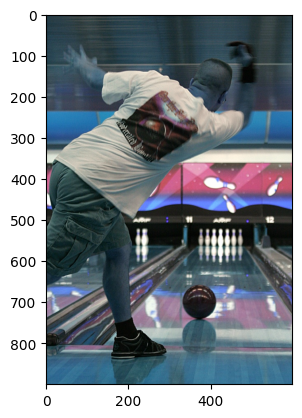

In [10]:
import glob
import random
import cv2
import matplotlib.pyplot as plt

train_image  = glob.glob("/content/city_problems/train/train/*.jpg")
test_image  = glob.glob("/content/city_problems/test/test/*.jpg")

all_images = train_image + test_image

print(len(train_image))
print(len(test_image))

num = random.randint(0,len(all_images))

image = cv2.imread(all_images[num])
plt.imshow(image, cmap="gray");


## 2. Ordenar el dataset

El dataset descargado contiene dos carpetas con imágenes, una para el subconjunto train y otra para el subconjunto test. En ambas carpetas podrás encontrar imágenes con extensión .jpeg, .jpg, y .png. Por otra parte, la carpeta también tiene un archivo CSV para el subconjunto train y otro archivo para el subconjunto test. Estos archivos contienen una etiqueta por cada imagen, por lo que podrían ser de bastante utilidad para implementar un modelo de inteligencia artificial para clasificar las imágenes con las clases respectivas: no hay evento, árbol caído, fuego, inundación, mal camino, atasco de tráfico, basura , y accidente de tráfico.

Usualmente, un dataset requiere de un orden o preprocesamiento antes de utilizarlo con un modelo de inteligencia artificial. La siguiente celda reorganiza el dataset en dos carpetas separadas, en las que crearemos una carpeta por cada una de las categorias existentes en el dataset.



In [11]:
TRAINSET_PATH = "/content/train_data"
TESTSET_PATH = "/content/test_data"
categories = ["no_event","fallen_tree","fire","flooding","bad_road","traffic_jam","garbage","traffic_accident"]

dataset = pd.read_csv('/content/city_problems/train.csv')

# Dividir el conjunto de datos en subconjuntos de entrenamiento y prueba con Scikit-learn
train, test = train_test_split(dataset, test_size=0.2)

train["image_path"] = " "
test["image_path"] = " "

def sort_subset(subset, target_path):
  ''' Esta función distribuye las imágenes desde una carpeta hacia múltiples
      carpetas, esto en base a las categorías a las que pertenecen las imágenes.
  '''
  # Comprobar si las nuevas carpetas para el dataset organizado ya fueron creadas
  if os.path.exists(target_path):
    !rm -rf "$target_path"

  !mkdir "$target_path"
  dirs = {}

  # Mover cada imagen a su carpeta respectiva
  for idx, category in enumerate(categories):
    !mkdir "$target_path/$category"
    dirs[idx] = target_path+"/"+category

  for idx, sample in tqdm(subset.iterrows(), total=len(subset)):
    image_name = subset.at[idx,"image_id"]
    category = subset.at[idx,"label"]

    new_path = dirs[category]+"/"+image_name

    shutil.copy("/content/city_problems/train/train/"+image_name,new_path)
    subset.at[idx,"image_path"] = new_path

  print("Done! ",target_path)
  return subset

train = sort_subset(train,TRAINSET_PATH)
test = sort_subset(test,TESTSET_PATH)

train = train.reset_index()
test = test.reset_index()

  0%|          | 0/12178 [00:00<?, ?it/s]

Done!  /content/train_data


  0%|          | 0/3045 [00:00<?, ?it/s]

Done!  /content/test_data


In [12]:
# Mostrar la nueva organización de carpetas en las carpetas train_data y test_data
print(os.listdir(TRAINSET_PATH))
print(os.listdir(TESTSET_PATH))

['bad_road', 'traffic_accident', 'no_event', 'garbage', 'fire', 'traffic_jam', 'fallen_tree', 'flooding']
['bad_road', 'traffic_accident', 'no_event', 'garbage', 'fire', 'traffic_jam', 'fallen_tree', 'flooding']


In [13]:
# Visualizar el dataframe train
print(train)

       index   image_id  label                                      image_path
0      13464  13464.jpg      7  /content/train_data/traffic_accident/13464.jpg
1      14827  14827.jpg      7  /content/train_data/traffic_accident/14827.jpg
2       3787   3787.jpg      1        /content/train_data/fallen_tree/3787.jpg
3       9654   9654.jpg      5        /content/train_data/traffic_jam/9654.jpg
4      13676  13676.jpg      7  /content/train_data/traffic_accident/13676.jpg
...      ...        ...    ...                                             ...
12173    465    465.jpg      0            /content/train_data/no_event/465.jpg
12174   5261   5261.jpg      2               /content/train_data/fire/5261.jpg
12175  10715  10715.jpg      5       /content/train_data/traffic_jam/10715.jpg
12176   7334  7334.jpeg      3          /content/train_data/flooding/7334.jpeg
12177  13055  13055.jpg      6           /content/train_data/garbage/13055.jpg

[12178 rows x 4 columns]


## 3. Visualizar un conjunto de imágenes

In [14]:
import pathlib

path = pathlib.Path("/etc/os-release")
print(path/"hello.txt")

/etc/os-release/hello.txt


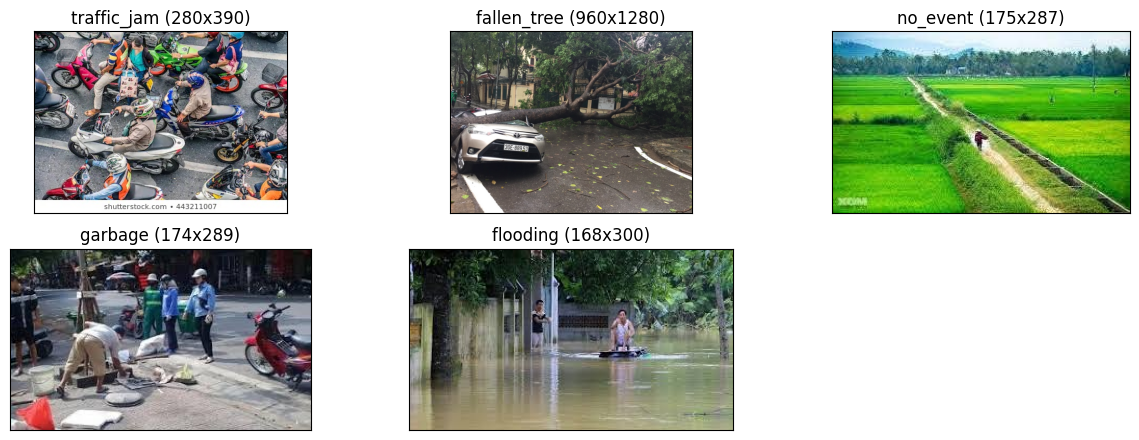

In [15]:
def visualize(image_array):
  '''
  Esta función crea una visualización con multiples imágenes
  '''
  plt.rcParams["figure.figsize"] = (15,8)

  for index, sample in enumerate(image_array):
    # Abrir la imagen actual
    img = cv2.imread(sample[0])
    # Convert la imagen actual a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Obtener el ancho y alto de la imagen
    # ancho = img.shape[0] Guardar el ancho de una imágen
    # alto = img.shape[1] Guardar el alto de una imágen

    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.title(sample[1]+" ("+str(img.shape[0])+"x"+str(img.shape[1])+")")
    plt.xticks([]), plt.yticks([])

random_category = random.randint(0,len(categories)-1)
images = []
num_images = 5 #@param {type:"number"} # Número de imágenes a mostrarse

for num in range(num_images):
  random_image = random.randint(0,len(train)-1) # Seleccionar imagen aleatoriamente
  images.append([train.at[random_image,"image_path"],categories[train.at[random_image,"label"]]])

visualize(images)

## **Ejercicio:** Dataset de Kaggle

Descargue un nuevo dataset publico desde el sitio web  Kaggle y resuelva los siguientes ejercicios en celdas separadas. Se sugiere que el dataset sea de clasificación (lo que quiere decir, que contenga etiquetas para cada imagen o archivo).

0. Crear un diccionario que contenga un registro por cada imagen/archivo en el dataset. El registro tendra que estar compuesto por ruta, categoría, alto, y ancho.
1. Realizar un análisis sobre cuantas imagenes se tiene por categoría en el dataset.
2. Mostrar un ejemplo por tipo de objeto o categoría.
3. Generar un gráfico con la distribución de tamaños (alto y ancho de las imágenes).
4. Mostrar cual es la categoría que mas y menos se repiten.

## **Ejercicio:** Quinua Real

Gracias a su alto valor nutricional, la quinua ha sido reconocida como un superalimento de importancia mundial, especialmente después de que las Naciones Unidas proclamaran el año 2013 como el "Año Internacional de la Quinua". Entre sus variedades, la quinua real —originaria exclusivamente del altiplano boliviano— destaca por poseer las propiedades nutricionales más elevadas. No obstante, su producción enfrenta limitaciones debido a la ausencia de herramientas eficaces para separar la quinua de impurezas como paja, barro y piedras, lo que obliga a realizar este proceso manualmente y con gran esfuerzo [1].

En ese sentido, en este ejercicio deberas trabajar con el siguiente dataset https://drive.google.com/file/d/1M5skIXyLsJ4Ymg5cCQYEvEjJWNV0EKbv/view?usp=sharing y deberas programar funciones para realizar un analisís preliminar del dataset.

1. Crear un diccionario que contenga un registro por cada imagen/archivo en el dataset. El registro tendra que estar compuesto por ruta, categoría, alto, y ancho de la imagen. Para esto último, puede usar el atributo `.shape` disponible después de abrir una imagen con opencv.
2. Realizar un análisis sobre cuantas imagenes se tiene por categoría en el dataset.
3. Mostrar un ejemplo de imagen por cada categoría.
4. Generar un gráfico con la distribución de tamaños (alto y ancho de las imágenes). Hacer uso matplotlib.
5. Mostrar cual es la categoría que mas y menos se repiten.

[1] E. Salcedo, C. Huanca, and P. Patzi, “Enabling Efficient Royal Quinoa Quality Inspection via Mobile‑based Foreign Body Detection,” in 2024 IEEE Latin American Conference on Computational Intelligence (LA‑CCI 2024), 2024, doi:10.1109/LA‑CCI62337.2024.10814753.